In [1]:
import numpy as np
import pandas as pd
import time
import math
import itertools
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def create_dir(path, log=False):
    if not os.path.exists(path):
        if log:
            print('The directory', path, 'does not exist and will be created')
        os.makedirs(path)
    else:
        if log:
            print('The directory', path, ' already exists')

In [3]:
folder = os.path.join('QA_results', str(123), 'output')

### QA vs min-cut runtime up to 27 agents

In [4]:
def collect_files(report_filename):

    IDP_brute_force = bool(int(report_filename.split('_')[-2][0]))
    IDP_topdown_min_cut = bool(int(report_filename.split('_')[-2][1]))
    IDP_min_cut_dwave_annealer = bool(int(report_filename.split('_')[-2][2]))

    report_file_obj = open(os.path.join(report_filename),'r')
    table_contents = [line.replace('\n','').split('__') for line in report_file_obj.readlines()]
    #view output table
    def highlight_false(s, column):
        is_false = pd.Series(data=False, index=s.index)
        is_false[column] = round(s.loc[column],2)<1.0
        return ['color: #ff8888' if is_false.any() else '' for v in is_false]

    base_cols = ['Distribution', 'No. of Agents']
    sub_cols = ['', '']

    if IDP_brute_force:
        base_cols = base_cols+['Brute Force']*3
        sub_cols=sub_cols+['Result', 'Value', 'TTE']
    if IDP_topdown_min_cut:
        base_cols = base_cols+['Top-down approach using min-cut']*4
        sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']
    if IDP_min_cut_dwave_annealer:
        base_cols = base_cols+['Dwave Annealer']*4
        sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']


    column_arrays = [base_cols, sub_cols]


    #df = pd.DataFrame(table_contents, columns=table_headers)
    df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))
    return df

In [5]:
pd.set_option('display.max_rows', None)

report_filename = "IDP_report_011_123.txt"
df = collect_files(report_filename)

df.head()

Distribution No. of Agents Top-down approach using min-cut  \
                                                      Result   
0      laplace             2                         ['1,2']   
1      laplace             3                    ['3', '1,2']   
2      laplace             4               ['2,4', '3', '1']   
3      laplace             5                ['1,2,5', '3,4']   
4      laplace             6              ['1,3,6', '2,4,5']   

                                                          Dwave Annealer  \
                Value                    TTE Quality              Result   
0                 2.5                    0.0       1             ['1,2']   
1                 2.5                    0.0       1        ['1,2', '3']   
2                2.89                    0.0       1   ['1', '3', '2,4']   
3  21.639999999999997                    0.0       1    ['1,2,5', '3,4']   
4  21.099999999999998  0.0010342597961425781       1  ['2,4,5', '1,3,6']   

                                                  
                Value                TTE Quality  
0                 2.5                0.0     1.0  
1                 2.5  5.190215110778809     1.0  
2                2.89  10.37340497970581     1.0  
3  21.639999999999997  9.827338695526123     1.0  
4  21.099999999999998  14.80012822151184     1.0

In [6]:
def plot_tte(folder, out_folder, df,
             log_scale=True, save=True, font=14, 
             labels=[['Top-down approach using min-cut', 'MIN-CUT'], ['Dwave Annealer', 'QA']]):
    
    current_folder = os.path.join(folder, out_folder )
    create_dir(current_folder)

    for distr in df.Distribution.unique():
        data = df[df.Distribution == distr]

        plt.figure(figsize=(8,5))
        x = data['No. of Agents'].to_numpy()


        y_BF = data[(labels[0][0], 'TTE')].astype(float).to_numpy()
        y_QA = data[(labels[1][0], 'TTE')].astype(float).to_numpy()

        if log_scale:
            y_BF = np.log(y_BF+1)
            y_QA = np.log(y_QA+1)
            file = os.path.join(current_folder, distr+'_log.png')
        else:
            file = os.path.join(current_folder, distr+'.png')
            
        plt.scatter(x, y_BF, label=labels[0][1])
        plt.plot(x, y_BF)

        plt.scatter(x, y_QA, label=labels[1][1])
        plt.plot(x, y_QA)

        plt.xticks(ticks=np.arange(0, 27, 3), fontsize =font+2)
        plt.yticks(fontsize =font+2)


        plt.xlabel(r'n° agents $(n)$',fontdict={'fontsize':font+2})
        plt.ylabel(r"(log scale) QA runtime - sec",fontdict={'fontsize':font+2})

        plt.grid(alpha=.5)
        plt.title(distr.capitalize(), fontdict={'fontsize':font+4})
        plt.legend(fontsize=font+2)
        

        if save:
            plt.savefig(file, dpi=300, bbox_inches = "tight")
        plt.show()

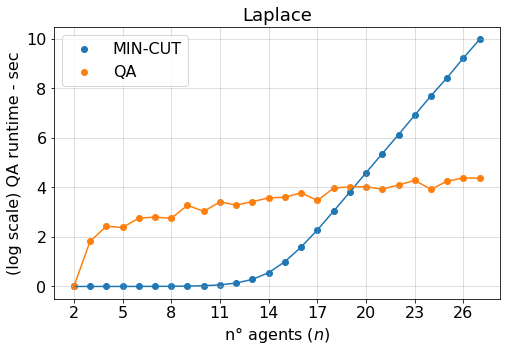

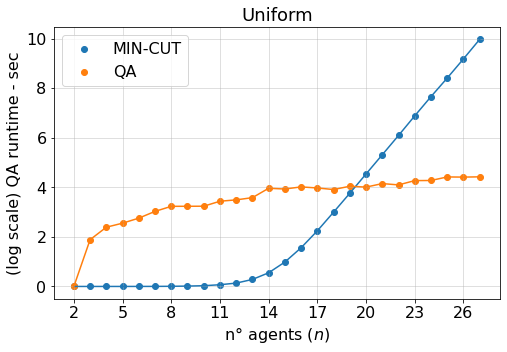

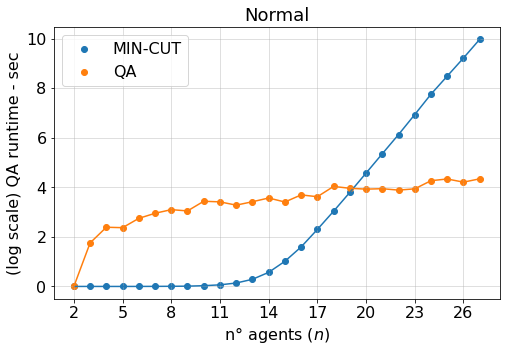

In [8]:
plot_tte(folder, out_folder= 'QA vs MIN-CUT', df=df, log_scale=True, save=True, font=14,
         labels = [['Top-down approach using min-cut', 'MIN-CUT'], ['Dwave Annealer', 'QA']] )

In [9]:
data = pd.concat([df["Distribution"] , df["No. of Agents"], df[('Dwave Annealer', 'Quality')]], axis = 1)
data.columns = ["Distribution", "n", "Quality"]
data.Quality = data.Quality.astype(float)
data['Error'] = 1-data.Quality
data.head()

,Distribution,n,Quality,Error
0,laplace,2,1.0,0.0
1,laplace,3,1.0,0.0
2,laplace,4,1.0,0.0
3,laplace,5,1.0,0.0
4,laplace,6,1.0,0.0


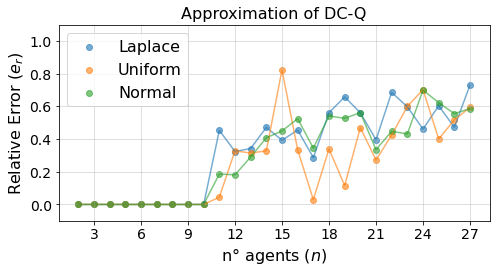

In [10]:
font=14

fig, ax = plt.subplots(figsize=(7,3.9))
fig.set_tight_layout(True)
# for i, g in data.groupby('Distribution'):
#     g.plot(x='n', y='Error', ax=ax, label=str(i), style='o-', alpha=.6)#, marker='8', markersize=8, alpha=.6)#, yerr='std_acc')
# #     plt.fill_between(x=g['n_agents'], y1 = g['time'] - g['std'], y2 = g['time'] + g['std'], alpha=0.2)


for distr in df.Distribution.unique():
    current_data = data[data.Distribution == distr]
    
    x = current_data['n'].to_numpy()

    y = current_data['Error'].astype(float).to_numpy()
    
    ax.plot(x, y, alpha=.6)
    ax.scatter(x, y, label=distr.capitalize(), alpha=.6)


ax.set_ylabel(r'Relative Error $(e_r)$',fontdict={'fontsize':font+2})

ax.set_xlabel(r'n° agents $(n)$',fontdict={'fontsize':font+2})
ax.set_ylim(-.1, 1.1)

ax.set_xticks(ticks=np.arange(1, 28, 3))
ax.set_yticks(ticks=np.arange(0, 1.1, .2))

ax.tick_params(axis='both', which='major', labelsize=font)

ax.grid(alpha=.5)
ax.legend(fontsize=font+2, loc="upper left")

ax.set_title("Approximation of DC-Q", fontsize = font+2)

file = os.path.join(folder, 'QA vs MIN-CUT', 'QA_Acc.png')
plt.savefig(file, dpi=500, bbox_inches = "tight")

### Quality

In [11]:
report_filename = "IDP_report_111_123.txt"
df = collect_files(report_filename)

# IDP_brute_force = bool(int(report_filename.split('_')[-2][0]))
# IDP_topdown_min_cut = bool(int(report_filename.split('_')[-2][1]))
# IDP_min_cut_dwave_annealer = bool(int(report_filename.split('_')[-2][2]))

# report_file_obj = open(os.path.join(report_filename),'r')
# table_contents = [line.replace('\n','').split('__') for line in report_file_obj.readlines()]

In [12]:
current_folder = file = os.path.join(folder, 'Quality')
create_dir(current_folder)

In [13]:
# #view output table
# def highlight_false(s, column):
#     is_false = pd.Series(data=False, index=s.index)
#     is_false[column] = round(s.loc[column],2)<1.0
#     return ['color: #ff8888' if is_false.any() else '' for v in is_false]

# base_cols = ['Distribution', 'No. of Agents']
# sub_cols = ['', '']

# if IDP_brute_force:
#     base_cols = base_cols+['Brute Force']*3
#     sub_cols=sub_cols+['Result', 'Value', 'TTE']
# if IDP_topdown_min_cut:
#     base_cols = base_cols+['Top-down approach using min-cut']*4
#     sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']
# if IDP_min_cut_dwave_annealer:
#     base_cols = base_cols+['Dwave Annealer']*4
#     sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']


# column_arrays = [base_cols, sub_cols]


# #df = pd.DataFrame(table_contents, columns=table_headers)
# df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))
# df.head()

In [14]:
data = pd.concat([df["Distribution"] , df["No. of Agents"], df[('Top-down approach using min-cut', 'Quality')]], axis = 1)
data.columns = ["Distribution", "n", "Quality"]
data.Quality = data.Quality.astype(float)
data['Error'] = 1-data.Quality
data.head()

,Distribution,n,Quality,Error
0,laplace,2,1.0,0.0
1,laplace,3,1.0,0.0
2,laplace,4,1.0,0.0
3,laplace,5,1.0,0.0
4,laplace,6,1.0,0.0


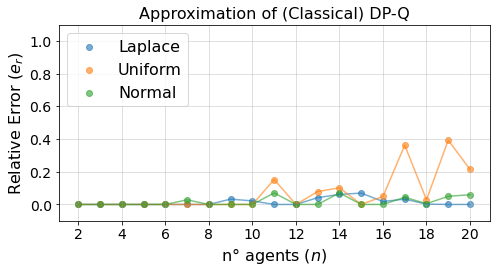

In [15]:
font=14

fig, ax = plt.subplots(figsize=(7,3.9))
fig.set_tight_layout(True)
# for i, g in data.groupby('Distribution'):
#     g.plot(x='n', y='Error', ax=ax, label=str(i), style='o-', alpha=.6)#, marker='8', markersize=8, alpha=.6)#, yerr='std_acc')
# #     plt.fill_between(x=g['n_agents'], y1 = g['time'] - g['std'], y2 = g['time'] + g['std'], alpha=0.2)


for distr in df.Distribution.unique():
    current_data = data[data.Distribution == distr]
    
    x = current_data['n'].to_numpy()

    y = current_data['Error'].astype(float).to_numpy()
    
    ax.plot(x, y, alpha=.6)
    ax.scatter(x, y, label=distr.capitalize(), alpha=.6)


ax.set_ylabel(r'Relative Error $(e_r)$',fontdict={'fontsize':font+2})

ax.set_xlabel(r'n° agents $(n)$',fontdict={'fontsize':font+2})
ax.set_ylim(-.1, 1.1)

ax.set_xticks(ticks=np.arange(0, 20, 2))
ax.set_yticks(ticks=np.arange(0, 1.1, .2))

ax.tick_params(axis='both', which='major', labelsize=font)

ax.grid(alpha=.5)
ax.legend(fontsize=font+2, loc="upper left")

ax.set_title("Approximation of (Classical) DP-Q", fontsize = font+2)

file = os.path.join(current_folder, 'MINCUT_Acc.png')
plt.savefig(file, dpi=500, bbox_inches = "tight")

In [16]:
data = pd.concat([df["Distribution"] , df["No. of Agents"], df[('Dwave Annealer', 'Quality')]], axis = 1)
data.columns = ["Distribution", "n", "Quality"]
data.Quality = data.Quality.astype(float)
data['Error'] = 1-data.Quality

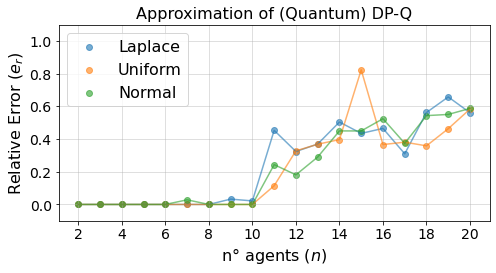

In [17]:
font=14

fig, ax = plt.subplots(figsize=(7,3.9))
fig.set_tight_layout(True)


for distr in df.Distribution.unique():
    current_data = data[data.Distribution == distr]
    
    x = current_data['n'].to_numpy()

    y = current_data['Error'].astype(float).to_numpy()
    
    ax.plot(x, y, alpha=.6)
    ax.scatter(x, y, label=distr.capitalize(), alpha=.6)


ax.set_ylabel(r'Relative Error $(e_r)$',fontdict={'fontsize':font+2})

ax.set_xlabel(r'n° agents $(n)$',fontdict={'fontsize':font+2})
ax.set_ylim(-.1, 1.1)

ax.set_xticks(ticks=np.arange(0, 20, 2))
ax.set_yticks(ticks=np.arange(0, 1.1, .2))

ax.tick_params(axis='both', which='major', labelsize=font)

ax.grid(alpha=.5)
ax.legend(fontsize=font+2, loc="upper left")


ax.set_title("Approximation of (Quantum) DP-Q", fontsize = font+2)

file = os.path.join(current_folder, 'QA_Acc.png')
plt.savefig(file, dpi=500, bbox_inches = "tight")

### QA runtime up to 65 agents

In [18]:
report_filename = "IDP_report_0001_123.txt"

IDP_brute_force = bool(int(report_filename.split('_')[-2][0]))
IDP_topdown_min_cut = bool(int(report_filename.split('_')[-2][1]))
IDP_topdown_qubo = bool(int(report_filename.split('_')[-2][2]))
IDP_min_cut_dwave_annealer = bool(int(report_filename.split('_')[-2][3]))

report_file_obj = open(os.path.join(report_filename),'r')
table_contents = [line.replace('\n','').split('__') for line in report_file_obj.readlines()]

In [19]:
current_folder = file = os.path.join(folder, 'QA_runtime')
create_dir(current_folder)

In [20]:
pd.set_option('display.max_rows', None)
df.head()

Distribution No. of Agents         Brute Force                      \
                                          Result               Value   
0      laplace             2             ['1,2']                 2.5   
1      laplace             3        ['3', '1,2']                 2.5   
2      laplace             4   ['2,4', '3', '1']                2.89   
3      laplace             5    ['1,2,5', '3,4']  21.639999999999997   
4      laplace             6  ['1,3,6', '2,4,5']  21.099999999999998   

                         Top-down approach using min-cut                      \
                     TTE                          Result               Value   
0  0.0009906291961669922                         ['1,2']                 2.5   
1                    0.0                    ['3', '1,2']                 2.5   
2                    0.0               ['2,4', '3', '1']                2.89   
3  0.0009961128234863281                ['1,2,5', '3,4']  21.639999999999997   
4   0.001994609832763672              ['1,3,6', '2,4,5']  21.099999999999998   

                                      Dwave Annealer                      \
                     TTE Quality              Result               Value   
0                    0.0     1.0             ['1,2']                 2.5   
1  0.0010154247283935547     1.0        ['3', '1,2']                 2.5   
2  0.0009951591491699219     1.0   ['1', '3', '2,4']                2.89   
3                    0.0     1.0    ['1,2,5', '3,4']  21.639999999999997   
4  0.0009975433349609375     1.0  ['1,3,6', '2,4,5']  21.099999999999998   

                               
                  TTE Quality  
0                 0.0     1.0  
1   5.409874200820923     1.0  
2   9.935318231582642     1.0  
3   10.16195011138916     1.0  
4  14.997750997543335     1.0

In [21]:
#view output table
def highlight_false(s, column):
    is_false = pd.Series(data=False, index=s.index)
    is_false[column] = round(s.loc[column],2)<1.0
    return ['color: #ff8888' if is_false.any() else '' for v in is_false]

base_cols = ['Distribution', 'No. of Agents']
sub_cols = ['', '']

if IDP_brute_force:
    base_cols = base_cols+['Brute Force']*3
    sub_cols=sub_cols+['Result', 'Value', 'TTE']
if IDP_topdown_min_cut:
    base_cols = base_cols+['Top-down approach using min-cut']*4
    sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']
if IDP_min_cut_dwave_annealer:
    base_cols = base_cols+['Dwave Annealer']*4
    sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']


column_arrays = [base_cols, sub_cols]


#df = pd.DataFrame(table_contents, columns=table_headers)
df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))
df.head()

Distribution No. of Agents      Dwave Annealer                      \
                                          Result               Value   
0      laplace             2             ['1,2']                 2.5   
1      laplace             3        ['1,2', '3']                 2.5   
2      laplace             4   ['1', '3', '2,4']                2.89   
3      laplace             5    ['1,2,5', '3,4']  21.639999999999997   
4      laplace             6  ['1,3,6', '2,4,5']  21.099999999999998   

                               
                  TTE Quality  
0                 0.0    None  
1   5.902053117752075    None  
2  10.362634420394897    None  
3  10.105842590332031    None  
4   15.85460352897644    None

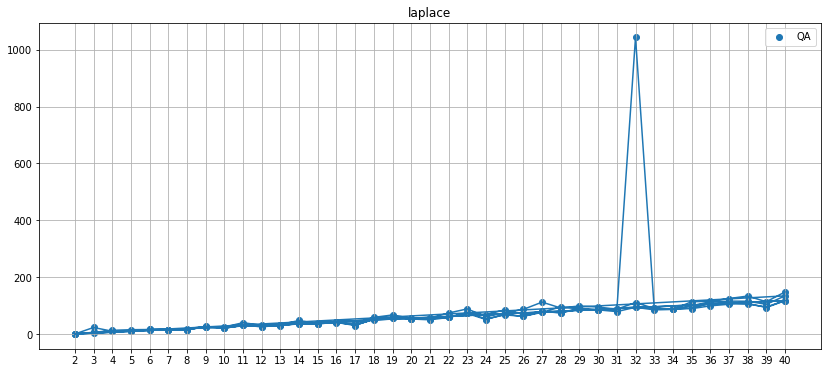

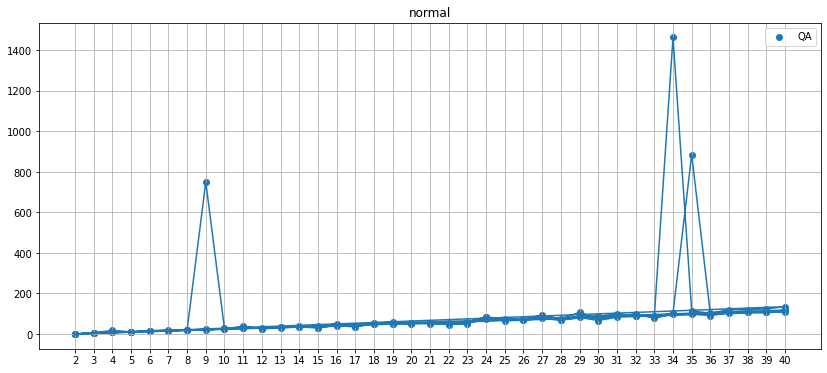

In [22]:
import matplotlib.pyplot as plt
for distr in df.Distribution.unique():
    data = df[df.Distribution == distr]
    
    
    plt.figure(figsize=(14,6))
    x = data['No. of Agents'].to_numpy()
    y_QA = data[('Dwave Annealer', 'TTE')].astype(float).to_numpy()
    
    plt.scatter(x, y_QA, label='QA')
    plt.plot(x, y_QA)
    
    plt.grid()
    plt.title(distr)
    plt.legend()
    file = os.path.join(current_folder, distr + '.png')
    plt.savefig(file, dpi=300, bbox_inches = "tight")
    plt.show()


In [23]:
report_filename = "IDP_report_011_123.txt"

IDP_brute_force = bool(int(report_filename.split('_')[-2][0]))
IDP_topdown_min_cut = bool(int(report_filename.split('_')[-2][1]))
IDP_min_cut_dwave_annealer = bool(int(report_filename.split('_')[-2][2]))

report_file_obj = open(os.path.join(report_filename),'r')
table_contents = [line.replace('\n','').split('__') for line in report_file_obj.readlines()]

In [24]:
current_folder = file = os.path.join(folder, 'QA_runtime')
create_dir(current_folder)

In [25]:
#view output table
def highlight_false(s, column):
    is_false = pd.Series(data=False, index=s.index)
    is_false[column] = round(s.loc[column],2)<1.0
    return ['color: #ff8888' if is_false.any() else '' for v in is_false]

base_cols = ['Distribution', 'No. of Agents']
sub_cols = ['', '']

if IDP_brute_force:
    base_cols = base_cols+['Brute Force']*3
    sub_cols=sub_cols+['Result', 'Value', 'TTE']
if IDP_topdown_min_cut:
    base_cols = base_cols+['Top-down approach using min-cut']*4
    sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']
if IDP_min_cut_dwave_annealer:
    base_cols = base_cols+['Dwave Annealer']*4
    sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']


column_arrays = [base_cols, sub_cols]


#df = pd.DataFrame(table_contents, columns=table_headers)
df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))
pd.set_option('display.max_rows', None)
df.head()

Distribution No. of Agents Top-down approach using min-cut  \
                                                      Result   
0      laplace             2                         ['1,2']   
1      laplace             3                    ['3', '1,2']   
2      laplace             4               ['2,4', '3', '1']   
3      laplace             5                ['1,2,5', '3,4']   
4      laplace             6              ['1,3,6', '2,4,5']   

                                                          Dwave Annealer  \
                Value                    TTE Quality              Result   
0                 2.5                    0.0       1             ['1,2']   
1                 2.5                    0.0       1        ['1,2', '3']   
2                2.89                    0.0       1   ['1', '3', '2,4']   
3  21.639999999999997                    0.0       1    ['1,2,5', '3,4']   
4  21.099999999999998  0.0010342597961425781       1  ['2,4,5', '1,3,6']   

                                                  
                Value                TTE Quality  
0                 2.5                0.0     1.0  
1                 2.5  5.190215110778809     1.0  
2                2.89  10.37340497970581     1.0  
3  21.639999999999997  9.827338695526123     1.0  
4  21.099999999999998  14.80012822151184     1.0

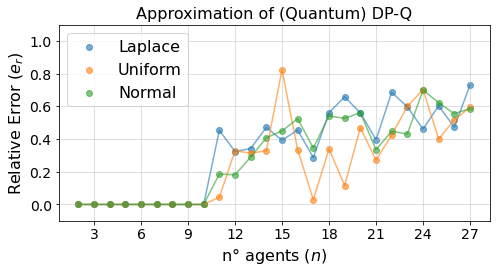

In [26]:
data = pd.concat([df["Distribution"] , df["No. of Agents"], df[('Dwave Annealer', 'Quality')]], axis = 1)
data.columns = ["Distribution", "n", "Quality"]
data.Quality = data.Quality.astype(float)

data['Error'] = 1-data.Quality

font=14

fig, ax = plt.subplots(figsize=(7,3.9))
fig.set_tight_layout(True)
# for i, g in data.groupby('Distribution'):
#     g.plot(x='n', y='Error', ax=ax, label=str(i), style='o-', alpha=.6)#, marker='8', markersize=8, alpha=.6)#, yerr='std_acc')
# #     plt.fill_between(x=g['n_agents'], y1 = g['time'] - g['std'], y2 = g['time'] + g['std'], alpha=0.2)


for distr in df.Distribution.unique():
    current_data = data[data.Distribution == distr]
    
    x = current_data['n'].to_numpy()

    y = current_data['Error'].astype(float).to_numpy()
    
    ax.plot(x, y, alpha=.6)
    ax.scatter(x, y, label=distr.capitalize(), alpha=.6)


ax.set_ylabel(r'Relative Error $(e_r)$',fontdict={'fontsize':font+2})

ax.set_xlabel(r'n° agents $(n)$',fontdict={'fontsize':font+2})
ax.set_ylim(-.1, 1.1)

ax.set_xticks(ticks=np.arange(1, 27, 3))
ax.set_yticks(ticks=np.arange(0, 1.1, .2))

ax.tick_params(axis='both', which='major', labelsize=font)

ax.grid(alpha=.5)
ax.legend(fontsize=font+2, loc="upper left")

plt.title("Approximation of (Quantum) DP-Q", fontsize = font+2)


file = os.path.join(current_folder, 'QA_Acc vs Min-cut.png')
plt.savefig(file, dpi=500, bbox_inches = "tight")

In [27]:
current_folder

'QA_results\\123\\output\\QA_runtime'